In [16]:
import matplotlib.pyplot as plt
from random import randint

from torch_geometric.datasets import Entities, Planetoid
from torch_geometric.explain import Explainer, GNNExplainer, PGExplainer, DummyExplainer

import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx

import torch
import torch.nn.functional as F

import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.explain.metric import fidelity, unfaithfulness

torch_geometric.seed_everything(41)

**Data**

In [5]:
dataset = Planetoid("../data", "Cora")
data = dataset[0]

**Model**

In [6]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)


model = GCN()

**Training**

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

**Eplainers**

In [10]:
gnnexplainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='phenomenon',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)


pgexplainer = Explainer(
    model=model,
    algorithm=PGExplainer(epochs=200),
    explanation_type='phenomenon',
    node_mask_type=None,
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)


dummyexplainer = Explainer(
    model=model,
    algorithm=DummyExplainer(),
    explanation_type='phenomenon',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

**Training Explainers**

In [11]:
#train PGExplainer
for epoch in range(200):
    num_nodes = randint(0,1000)
    for node_index in range(num_nodes, num_nodes+200):  
        loss = pgexplainer.algorithm.train(epoch, model, data.x, data.edge_index, target=data.y, index=node_index)
    print(f"Loss {loss} in epoch {epoch}")

Loss 1.8695334196090698 in epoch 0
Loss 2.0113525390625 in epoch 1
Loss 1.652524471282959 in epoch 2
Loss 1.3816651105880737 in epoch 3
Loss 0.37213951349258423 in epoch 4
Loss 1.9950064420700073 in epoch 5
Loss 1.4959083795547485 in epoch 6
Loss 2.241579294204712 in epoch 7
Loss 2.049604654312134 in epoch 8
Loss 1.9082112312316895 in epoch 9
Loss 1.9610811471939087 in epoch 10
Loss 2.2317724227905273 in epoch 11
Loss 2.321577310562134 in epoch 12
Loss 2.244025945663452 in epoch 13
Loss 1.6675055027008057 in epoch 14
Loss 2.267577886581421 in epoch 15
Loss 1.871106505393982 in epoch 16
Loss 1.150529384613037 in epoch 17
Loss 1.6109330654144287 in epoch 18
Loss 1.9863232374191284 in epoch 19
Loss 1.748920202255249 in epoch 20
Loss 1.8929651975631714 in epoch 21
Loss 1.8405265808105469 in epoch 22
Loss 1.445170521736145 in epoch 23
Loss 0.5599075555801392 in epoch 24
Loss 1.8077991008758545 in epoch 25
Loss 1.8382214307785034 in epoch 26
Loss 2.0660297870635986 in epoch 27
Loss 1.2977519

**Probing Explainers**

In [12]:
gnnexplainer_Unfaithfulness = []
pgexplainer_Unfaithfulness = []
dummyepxplainer_Unfaithfulness = []
#Calculate unfaithfulness for first n nodes
for node_index in range(0,20):    
    gnnexplanation = gnnexplainer(data.x, data.edge_index, index=node_index, target=data.y)
    gnn_unf = unfaithfulness(gnnexplainer, gnnexplanation)
    
    pgexplanation = pgexplainer(data.x, data.edge_index, index=node_index, target=data.y)
    pg_unf = unfaithfulness(pgexplainer, pgexplanation)
    
    dummyexplanation = dummyexplainer(data.x, data.edge_index, index=node_index, target=data.y)
    dummy_unf = unfaithfulness(dummyexplainer, dummyexplanation)
    
    gnnexplainer_Unfaithfulness.append(gnn_unf)
    pgexplainer_Unfaithfulness.append(pg_unf)
    dummyepxplainer_Unfaithfulness.append(dummy_unf)
    
    print(f"GNNExplainer unfaithfulness: {gnn_unf}")
    print(f"PGExplainer unfaithfulness: {pg_unf}")
    print(f"DummyExplainer unfaithfulness: {dummy_unf} \n\n")

GNNExplainer unfaithfulness: 0.024875342845916748
PGExplainer unfaithfulness: 0.7078797817230225
DummyExplainer unfaithfulness: 0.5534732639789581 


GNNExplainer unfaithfulness: 0.010392189025878906
PGExplainer unfaithfulness: 0.7828845381736755
DummyExplainer unfaithfulness: 0.10157191753387451 


GNNExplainer unfaithfulness: 0.02174079418182373
PGExplainer unfaithfulness: 0.6843279004096985
DummyExplainer unfaithfulness: 0.6011621654033661 


GNNExplainer unfaithfulness: 0.03926551342010498
PGExplainer unfaithfulness: 0.5815251767635345
DummyExplainer unfaithfulness: 0.19657433032989502 


GNNExplainer unfaithfulness: 0.030691683292388916
PGExplainer unfaithfulness: 0.569733053445816
DummyExplainer unfaithfulness: 0.47350192070007324 


GNNExplainer unfaithfulness: 0.02349257469177246
PGExplainer unfaithfulness: 0.7470407783985138
DummyExplainer unfaithfulness: 0.4469146728515625 


GNNExplainer unfaithfulness: 0.052019715309143066
PGExplainer unfaithfulness: 0.5975433886051178
Dumm

Text(0.5, 1.0, 'Unfaitfulness on Dataset Cora')

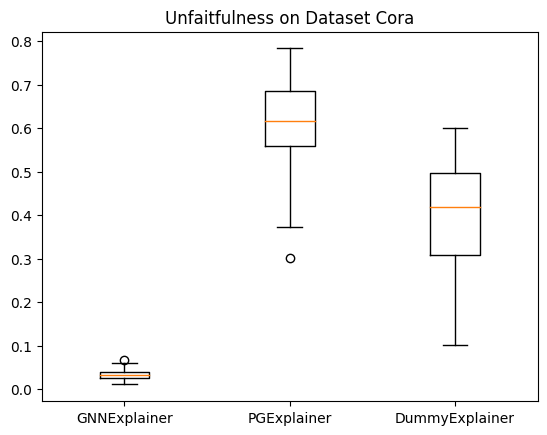

In [17]:
plt.boxplot([gnnexplainer_Unfaithfulness, pgexplainer_Unfaithfulness , dummyepxplainer_Unfaithfulness],labels=["GNNExplainer","PGExplainer","DummyExplainer"])
plt.title(f"Unfaitfulness on Dataset {dataset.name}")